In [1]:
import matplotlib.pyplot as plt
import random
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
%matplotlib inline
from torchvision.models import ResNet50_Weights
import torchvision

In [2]:
BASE = 'data/train/'
classes = os.listdir(BASE)
print(classes)

['Motorcycle', 'Car', 'Bicycle', 'Van', 'Bus', 'Truck']


In [3]:
dataset = {}
for vehicle_class in classes:
    dataset[vehicle_class] = [i for i in os.listdir(BASE + vehicle_class)]

In [4]:
print(dataset.keys())
print(len(dataset.keys()))

dict_keys(['Motorcycle', 'Car', 'Bicycle', 'Van', 'Bus', 'Truck'])
6


In [5]:
df = pd.DataFrame.from_dict(dataset, orient='index')
df = df.transpose()

In [6]:
df.head()

,Motorcycle,Car,Bicycle,Van,Bus,Truck
0,004077_10.jpg,004143_02.jpg,001391_05.jpg,003129_01.jpg,003920_01.jpg,003743_01.jpg
1,000821_18.jpg,001525_01.jpg,002928_01.jpg,002933_10.jpg,003978_09.jpg,001267_18.jpg
2,000758_19.jpg,002295_02.jpg,004921_09.jpg,000513_05.jpg,000330_09.jpg,003901_02.jpg
3,002541_10.jpg,002270_17.jpg,000235_08.jpg,000151_08.jpg,000777_10.jpg,000494_00.jpg
4,000743_04.jpg,001144_02.jpg,004280_05.jpg,004668_09.jpg,001092_10.jpg,001533_02.jpg


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200 entries, 0 to 1199
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Motorcycle  1200 non-null   object
 1   Car         1200 non-null   object
 2   Bicycle     1200 non-null   object
 3   Van         811 non-null    object
 4   Bus         1200 non-null   object
 5   Truck       1200 non-null   object
dtypes: object(6)
memory usage: 56.4+ KB


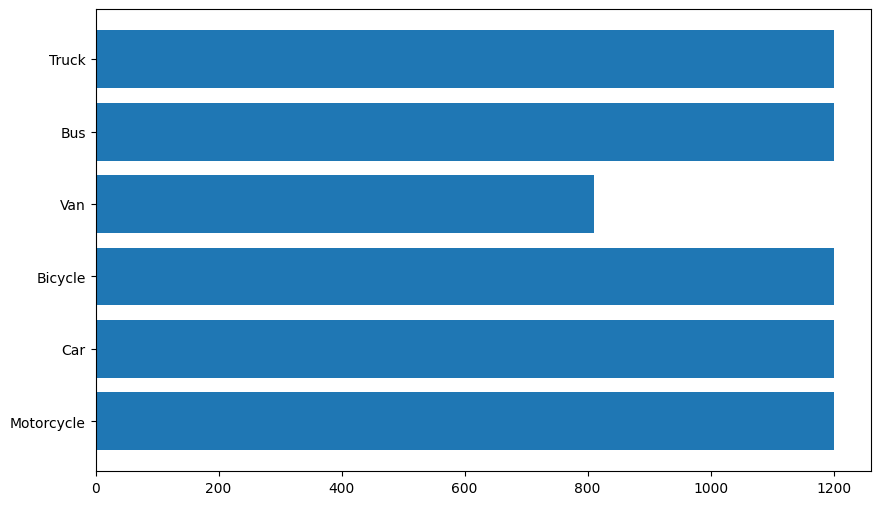

In [8]:
cols = []
col_imgs = []
for col in df.columns:
    cols.append(col)
    col_imgs.append(df[col].count())

plt.figure(figsize=(10,6))
plt.barh(cols, col_imgs)
plt.show()

Displaying 4 ranndom image per vehicle class


<Figure size 640x480 with 0 Axes>

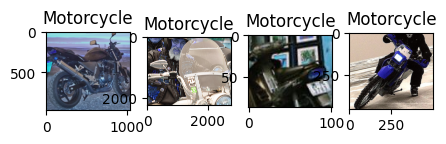

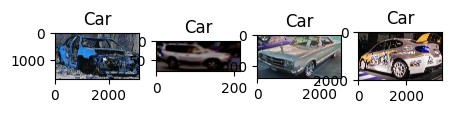

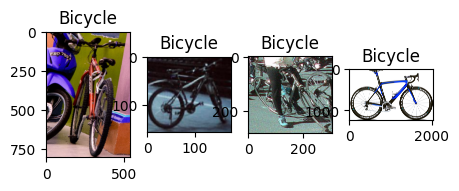

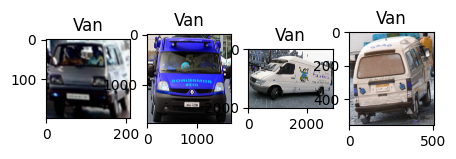

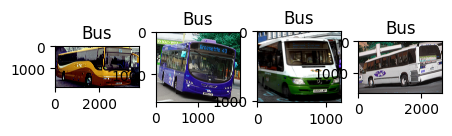

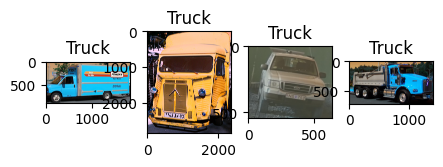

In [9]:
print("="*70)
print("Displaying 4 ranndom image per vehicle class")
print("="*70)

# for every class in `cols`
for j in range(len(classes)):
    plt.figure(j)
    plt.figure(figsize=(5,5))
    
    # 4 images per every class
    for i in range(4):
        id = "14{}".format(i+1)
        plt.subplot(int(id))
        random_file = random.choice(os.listdir(BASE + cols[j] + "/"))
        img = cv2.imread(BASE + cols[j] + "/" + random_file)
        plt.title(cols[j])
        plt.imshow(img)
plt.show()

In [10]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet's mean and std
])

In [11]:
from torchvision.datasets import ImageFolder

train_data_path = "data/train"
val_data_path = "data/test"

train_dataset = ImageFolder(root=train_data_path, transform=transform)
val_dataset = ImageFolder(root=val_data_path, transform=transform)


In [12]:
from torch.utils.data import DataLoader

batch_size = 32 

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [13]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated


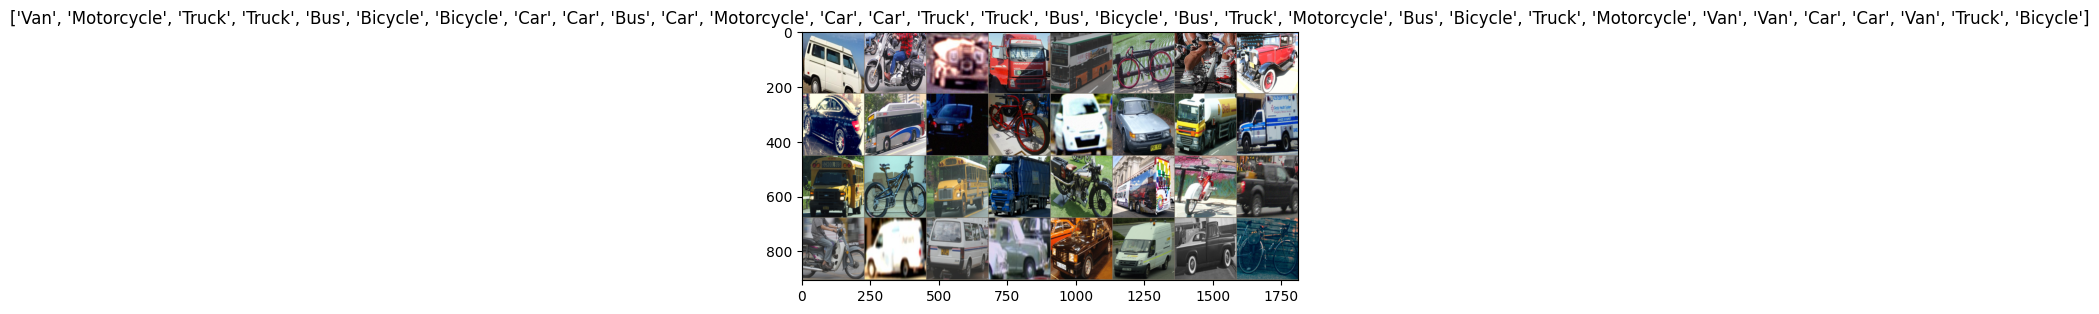

In [14]:
# Get a batch of training data
images, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(images)

imshow(out, title=[train_dataset.classes[x] for x in classes])


In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

weights = ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights)

# Freeze all layers in the network
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=3e-4)


In [16]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train() 
    train_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad() 

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():  # Turn off gradients for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    val_loss = val_loss / len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, '
          f'Val Loss: {val_loss:.4f}')

print('Training complete')


Epoch 1/10, Train Loss: 1.3650, Val Loss: 0.8494
Epoch 2/10, Train Loss: 0.7047, Val Loss: 0.6348
Epoch 3/10, Train Loss: 0.5789, Val Loss: 0.5643
Epoch 4/10, Train Loss: 0.5071, Val Loss: 0.5210
Epoch 5/10, Train Loss: 0.4698, Val Loss: 0.5010
Epoch 6/10, Train Loss: 0.4452, Val Loss: 0.4718
Epoch 7/10, Train Loss: 0.4116, Val Loss: 0.4580
Epoch 8/10, Train Loss: 0.3988, Val Loss: 0.4502
Epoch 9/10, Train Loss: 0.3875, Val Loss: 0.4368
Epoch 10/10, Train Loss: 0.3733, Val Loss: 0.4419
Training complete


In [17]:
torch.save(model.state_dict(), 'vehicle_classification_model.pth')

In [18]:
model = models.resnet50(weights=None)  # Initialize the model
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))  # Adjust for the number of classes

model.load_state_dict(torch.load('vehicle_classification_model.pth'))
model = model.to(device)

In [19]:
model.eval() 
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(val_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Test Loss: 0.4419, Test Accuracy: 84.44%


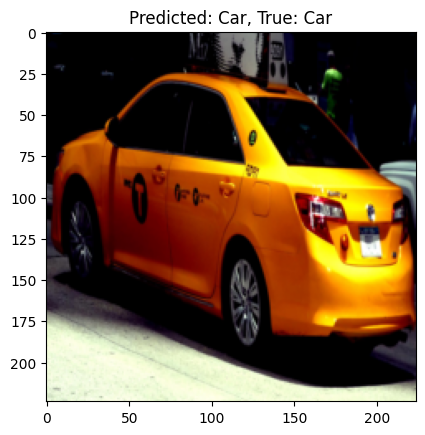

In [70]:
random_idx = random.randint(0, len(val_dataset) - 1)
image, true_label = val_dataset[random_idx]
image_show = image
image_show.numpy().transpose((1,2,0))
if not isinstance(image, Image.Image):
    # Convert to PIL Image if it's not
    image = transforms.ToPILImage()(image)

transform = val_dataset.transform  
image = transform(image).unsqueeze(0)

image = image.to(device)
with torch.no_grad():
    outputs = model(image)
    _, predicted = torch.max(outputs, 1)
    predicted_label = val_dataset.classes[predicted.item()]

image = image.squeeze(0) 
imshow(image_show.cpu(), title=f'Predicted: {predicted_label}, True: {val_dataset.classes[true_label]}')